##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemma - Common use cases
This notebook demonstrates the basic task that Gemma can solve by using the right prompting.
<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/Common_use_cases.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Setup

### Select the Colab runtime
To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to run the Gemma model. In this case, you can use a T4 GPU:

1. In the upper-right of the Colab window, select **▾ (Additional connection options)**.
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **T4 GPU**.

### Gemma setup

To complete this tutorial, you'll first need to complete the setup instructions at [Gemma setup](https://ai.google.dev/gemma/docs/setup). The Gemma setup instructions show you how to do the following:

* Get access to Gemma on kaggle.com.
* Select a Colab runtime with sufficient resources to run
  the Gemma 2B model.
* Generate and configure a Kaggle username and an API key as Colab secrets.

After you've completed the Gemma setup, move on to the next section, where you'll set environment variables for your Colab environment.


### Configure your credentials

Add your your Kaggle credentials to the Colab Secrets manager to securely store it.

1. Open your Google Colab notebook and click on the 🔑 Secrets tab in the left panel. <img src="https://storage.googleapis.com/generativeai-downloads/images/secrets.jpg" alt="The Secrets tab is found on the left panel." width=50%>
2. Create new secrets: `KAGGLE_USERNAME` and `KAGGLE_KEY`
3. Copy/paste your username into `KAGGLE_USERNAME`
3. Copy/paste your key into `KAGGLE_KEY`
4. Toggle the buttons on the left to allow notebook access to the secrets.


In [ ]:
import os
from google.colab import userdata

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.
os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")

### Install dependencies
Run the cell below to install all the required dependencies.

In [ ]:
!pip install -q -U keras keras-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 95.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 85.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible

## Exploring prompting capabilities

### Gemma

**About Gemma**

Gemma is a family of lightweight, state-of-the-art open models from Google, built from the same research and technology used to create the Gemini models. They are text-to-text, decoder-only large language models, available in English, with open weights, pre-trained variants, and instruction-tuned variants. Gemma models are well-suited for a variety of text generation tasks, including question answering, summarization, and reasoning. Their relatively small size makes it possible to deploy them in environments with limited resources such as a laptop, desktop or your own cloud infrastructure, democratizing access to state of the art AI models and helping foster innovation for everyone.

**Prompt formatting**

Instruction-tuned (IT) models are trained with a specific formatter that annotates all instruction tuning examples with extra information, both at training and inference time. The formatter has two purposes:

* Indicating roles in a conversation, such as the system, user, or assistant roles.
* Delineating turns in a conversation, especially in a multi-turn conversation.

Below, we specify the control tokens used by Gemma and their use cases. Note that the control tokens are reserved in and specific to our tokenizer.

* Token to indicate a user turn: `user`
* Token to indicate a model turn: `model`
* Token to indicate the beginning of dialogue turn: `<start_of_turn>`
* Token to indicate the end of dialogue turn: `<end_of_turn>`

Here's the [official documentation](https://ai.google.dev/gemma/docs/formatting) regarding prompting instruction-tuned models.

In [ ]:
import keras
import keras_nlp
from IPython.display import display, Markdown, Latex

os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")

In [ ]:
# Let's load Gemma using Keras
gemma_model_id = "gemma_1.1_instruct_2b_en"
gemma = keras_nlp.models.GemmaCausalLM.from_preset(gemma_model_id)

Attaching 'metadata.json' from model 'keras/gemma/keras/gemma_1.1_instruct_2b_en/3' to your Colab notebook...
Attaching 'metadata.json' from model 'keras/gemma/keras/gemma_1.1_instruct_2b_en/3' to your Colab notebook...
Attaching 'task.json' from model 'keras/gemma/keras/gemma_1.1_instruct_2b_en/3' to your Colab notebook...
Attaching 'config.json' from model 'keras/gemma/keras/gemma_1.1_instruct_2b_en/3' to your Colab notebook...
Attaching 'metadata.json' from model 'keras/gemma/keras/gemma_1.1_instruct_2b_en/3' to your Colab notebook...
Attaching 'metadata.json' from model 'keras/gemma/keras/gemma_1.1_instruct_2b_en/3' to your Colab notebook...
Attaching 'config.json' from model 'keras/gemma/keras/gemma_1.1_instruct_2b_en/3' to your Colab notebook...
Attaching 'config.json' from model 'keras/gemma/keras/gemma_1.1_instruct_2b_en/3' to your Colab notebook...
Attaching 'model.weights.h5' from model 'keras/gemma/keras/gemma_1.1_instruct_2b_en/3' to your Colab notebook...
Attaching 'metada

#### Prompting example: Summarization

In [ ]:
prompt = """<start_of_turn>user

Text:
Tech giant Google, originally a Stanford research project by Larry Page and Sergey Brin,
has become synonymous with searching the web. Their complex algorithms prioritize relevant
results, making Google the go-to platform for information seekers. Beyond search,
Google offers email (Gmail), document creation tools (Google Docs), mapping (Google Maps),
the Android operating system for smartphones, and the Chrome web browser.
A leader in AI, Google ventures into self-driving cars and quantum computing.
Their influence is so vast, "to google" has become a verb for searching online.

Could you summarize the text in a few words?<end_of_turn>
<start_of_turn>model"""

response = gemma.generate(prompt, max_length=512)
display(Markdown(response[len(prompt) :]))

Summary:
Google is a tech giant known for its search engine, email, documents, maps, and more, encompassing various products and services.

#### Prompting example: Reasoning

In [ ]:
prompt = """<start_of_turn>user
Think and write your step-by-step reasoning before responding.

Explain why the sky is blue.<end_of_turn>
<start_of_turn>model"""

response = gemma.generate(prompt, max_length=1024)
display(Markdown(response[len(prompt) :]))

**Step 1: Understand the physics of light scattering.**

- Light is composed of different wavelengths, each with a distinct color.
- When sunlight enters the atmosphere, it is scattered by molecules and particles in the air.


**Step 2: Explain the blue wavelength's scattering effect.**

- Blue light has a shorter wavelength than other colors in the spectrum.
- When blue light interacts with molecules in the atmosphere, it is scattered more strongly than other colors.


**Step 3: Describe the scattering process.**

- Blue light is scattered more efficiently by nitrogen molecules than by oxygen molecules.
- This means that more blue light reaches our eyes from the sky than other colors.


**Step 4: Quantify the effect.**

- The blue sky effect is most pronounced on a clear, sunny day with a high concentration of nitrogen molecules in the atmosphere.
- Studies have shown that the blue sky effect accounts for about 47% of the visible light that reaches our eyes from the sky.


**Step 5: Conclusion.**

- The blue sky is caused by the scattering of blue light by molecules in the atmosphere.
- This scattering effect is responsible for the blue color we perceive in the sky.

#### Prompting example: Classification

In [ ]:
prompt = """<start_of_turn>user
Classify the text into neutral, negative, or positive.
Generate only the class, nothing else.
Text: Text: I think the food was awesome.<end_of_turn>
<start_of_turn>model
Sentiment:"""

response = gemma.generate(prompt, max_length=64)
print("Sentiment: " + response[len(prompt) :])

Sentiment:  Positive


#### Prompting example: Extraction

In [ ]:
text = """Lost in a worn Berlin travel guide, Ania underlined Warsaw and London.
Two cities, two dreams: a bustling career in finance and
a cozy bookshop tucked away in a cobbled London street."""

prompt = f"""<start_of_turn>user
Your task is to find all the city names in the given text.
Your response is an array of the model names in the format [\"city_name\"].
If you don't find model names in the abstract or you are not sure, return [\"\"]

Text:
{text}<end_of_turn>
<start_of_turn>model"""

response = gemma.generate(prompt, max_length=512)
print("Extracted cities: " + response[len(prompt) :])

Extracted cities: ["Berlin", "Warsaw", "London"]


#### Prompting example: Multi-turn dialogue

In [ ]:
import textwrap


def format_messages(messages):
    fmt_messages = [
        f"<start_of_turn>{author}\n{text}<end_of_turn>" for author, text in messages
    ]
    fmt_messages.append("<start_of_turn>model")
    return "\n".join(fmt_messages)


history = [
    (
        "user",
        "You're a helpful assistant. Answer user's question in a friendly and helpful way. "
        "Please introduce yourself first.",
    )
]

print("\n*** YOU'RE ENTERING CHAT MODE. TYPE 'EXIT' TO FINISH THE CHAT ***\n")
while True:
    prompt = format_messages(history)
    response = gemma.generate(prompt, max_length=512)
    response = response[len(prompt) :]

    history.append(("model", response))
    print(textwrap.fill(f"Gemma: {response} \n", 120))

    question = input("User: ")
    if question == "EXIT":
        break

    print()
    history.append(("user", question))


*** YOU'RE ENTERING CHAT MODE. TYPE 'EXIT' TO FINISH THE CHAT ***

Gemma:  Hi there! I'm your friendly AI assistant here to help you with any questions or tasks you may have. I'm here
to assist you with information, provide solutions, and make your experience more efficient. Let's get started!
User: Who are you?

Gemma:  I am a large language model, trained by Google. I am designed to provide helpful and informative responses
based on the vast amount of data I have been trained on. I am here to assist you with your questions and requests to the
best of my abilities.
User: EXIT


#### Prompting example: Code Generation
_Note: While Gemma offers some basic code generation capabilities, a more specialized model called CodeGemma is introduced in the next section for these tasks._

In [ ]:
prompt = """<start_of_turn>user
Generate a Python function that multiplies two numbers<end_of_turn>
<start_of_turn>model"""

response = gemma.generate(prompt, max_length=1024)
display(Markdown(response[len(prompt) :]))

```python
def multiply(num1, num2):
  """
  This function multiplies two numbers.

  Args:
    num1: The first number.
    num2: The second number.

  Returns:
    The product of num1 and num2.
  """

  product = num1 * num2
  return product
```

**Example Usage:**

```python
# Multiply 5 and 3
product = multiply(5, 3)

# Print the product
print(product)  # Output: 15
```

**Explanation:**

* The function takes two arguments, `num1` and `num2`.
* Inside the function, we use the multiplication operator (`*`) to calculate the product of `num1` and `num2`.
* The product is stored in the `product` variable.
* The function returns the calculated product.

**Additional Notes:**

* This function only works for positive numbers. For negative numbers, a `ZeroDivisionError` will be raised.
* The function is designed to be simple and efficient. It does not handle errors or special cases.

In [ ]:
# We need to restart the session to release GPU memory
# before loading different model
get_ipython().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### CodeGemma

CodeGemma models are text-to-text and text-to-code decoder-only models that specializes in code completion and code generation tasks. The CodeGemma 2B and 7B variants are specially tuned for code infilling tasks.

This example uses CodeGemma's fill-in-the-middle (FIM) capability to complete code based on the surrounding context. This is particularly useful in code editor applications for inserting code where the text cursor is based on the code around it (before and after the cursor).

CodeGemma lets you use 4 user-defined tokens - 3 (`<|fim_prefix|>`, `<|fim_suffix|>`, `<|fim_middle|>`) for FIM and a `<|file_separator|>` token for multi-file context support. Use these to define constants. More about that in the next cells.


In [ ]:
import os
import keras
import keras_nlp
from google.colab import userdata

keras.config.set_floatx("bfloat16")
os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")

In [ ]:
# Load CodeGemma
codegemma = keras_nlp.models.GemmaCausalLM.from_preset("code_gemma_1.1_2b_en")

100%|██████████| 143/143 [00:00<00:00, 126kB/s]


100%|██████████| 501/501 [00:00<00:00, 428kB/s]


100%|██████████| 4.67G/4.67G [02:25<00:00, 34.4MB/s]


100%|██████████| 315/315 [00:00<00:00, 413kB/s]


100%|██████████| 4.04M/4.04M [00:00<00:00, 7.16MB/s]


In [ ]:
# Tokens
BEFORE_CURSOR = "<|fim_prefix|>"
AFTER_CURSOR = "<|fim_suffix|>"
AT_CURSOR = "<|fim_middle|>"
FILE_SEPARATOR = "<|file_separator|>"
END_TOKEN = codegemma.preprocessor.tokenizer.end_token
stop_tokens = (BEFORE_CURSOR, AFTER_CURSOR, AT_CURSOR, FILE_SEPARATOR, END_TOKEN)

In [ ]:
stop_token_ids = tuple(
    codegemma.preprocessor.tokenizer.token_to_id(x) for x in stop_tokens
)

#### Prompting example: Code infilling

In [ ]:
import re


# Helpers
def split_response_by_token(response):
    mapping = {}
    parts = re.split(r"(<\|[^\|\>]+\|\>)", response)
    parts = [item for item in parts if len(item)]
    for token in stop_tokens[:3]:
        mapping[token] = ""

        try:
            idx = parts.index(token)
            if parts[idx + 1] not in stop_tokens:
                mapping[token] = parts[idx + 1]
        except (ValueError, IndexError):
            pass

    return mapping

In [ ]:
prefix = "def calculate_area_of_rectangle(a: int, b: int) -> int:"
suffix = "\n    return area"
prompt = f"<|fim_prefix|>{prefix}<|fim_suffix|>{suffix}<|fim_middle|>"

response = codegemma.generate(prompt, stop_token_ids=stop_token_ids)
parts = split_response_by_token(response)

print("--- RAW Response ---")
print(response)

print("\n--- The generated (FIM) piece of code: ---")
print(parts[AT_CURSOR])

print("\n--- The whole function: ---")
print(parts[BEFORE_CURSOR], parts[AT_CURSOR], parts[AFTER_CURSOR])

--- RAW Response ---
<|fim_prefix|>def calculate_area_of_rectangle(a: int, b: int) -> int:<|fim_suffix|>
    return area<|fim_middle|>
    """
    Calculate the area of a rectangle.

    Args:
        a (int): The length of the rectangle.
        b (int): The width of the rectangle.

    Returns:
        int: The area of the rectangle.
    """
    area = a * b<|file_separator|>

--- The generated (FIM) piece of code: ---

    """
    Calculate the area of a rectangle.

    Args:
        a (int): The length of the rectangle.
        b (int): The width of the rectangle.

    Returns:
        int: The area of the rectangle.
    """
    area = a * b

--- The whole function: ---
def calculate_area_of_rectangle(a: int, b: int) -> int: 
    """
    Calculate the area of a rectangle.

    Args:
        a (int): The length of the rectangle.
        b (int): The width of the rectangle.

    Returns:
        int: The area of the rectangle.
    """
    area = a * b 
    return area


#### Prompting example: Code Generation
_Note: While the 2B version of CodeGemma was primarily designed for code completion, it can also handle basic code generation tasks. However, for optimal code generation results, we recommend using the instruction-tuned 7B model._

In [ ]:
prompt = """Write a one-liner in Python that check if a year is a leap year.
Examples:
>>> is_a_leap_year(2016)
True
>>> is_a_leap_year(2001)
False
>>> is_a_leap_year(2052)
True
def is_a_leap_year(year: int) -> bool:"""

response = codegemma.generate(prompt, max_length=128)
print(response)

Write a one-liner in Python that check if a year is a leap year.
Examples:
>>> is_a_leap_year(2016)
True
>>> is_a_leap_year(2001)
False
>>> is_a_leap_year(2052)
True
def is_a_leap_year(year: int) -> bool:
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)
<|file_separator|>


In [ ]:
# We need to restart the session to erase GPU RAM memory
# and load a new model
get_ipython().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### PaliGemma

PaliGemma is a lightweight open vision-language model (VLM) inspired by PaLI-3, and based on open components like the SigLIP vision model and the Gemma language model. PaliGemma takes both images and text as inputs and can answer questions about images with detail and context, meaning that PaliGemma can perform deeper analysis of images and provide useful insights, such as captioning for images and short videos, object detection, and reading text embedded within images.

Prompting:

* `cap {lang}\n`: Very raw short caption (from WebLI-alt)
* `caption {lang}\n`: Nice, COCO-like short captions
* `describe {lang}\n`: Somewhat longer, more descriptive captions
* `ocr`: Optical character recognition
* `answer en {question}\n`: Question answering about the image contents
* `question {lang} {answer}\n`: Question generation for a given answer
* `detect {object} ; {object}\n`: Count objects in a scene and return the bounding boxes for the objects
* `segment {object}\n`: Do image segmentation of the object in the scene

In [ ]:
import os
import keras
import keras_nlp
from google.colab import userdata

keras.config.set_floatx("bfloat16")
os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")

In [ ]:
# Load PaliGemma
paligemma = keras_nlp.models.PaliGemmaCausalLM.from_preset("pali_gemma_3b_mix_224")

100%|██████████| 861/861 [00:00<00:00, 782kB/s]
100%|██████████| 5.45G/5.45G [03:14<00:00, 30.1MB/s]
100%|██████████| 410/410 [00:00<00:00, 302kB/s]
100%|██████████| 4.07M/4.07M [00:00<00:00, 6.34MB/s]


In [ ]:
import io
import re
import PIL
import requests
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Helpers:

headers = {"User-Agent": "My User Agent 1.0"}


def crop_and_resize(image, target_size):
    """A helper function the resizes given image to the given shape"""
    width, height = image.size
    source_size = min(image.size)
    left = width // 2 - source_size // 2
    top = height // 2 - source_size // 2
    right, bottom = left + source_size, top + source_size
    return image.resize(target_size, box=(left, top, right, bottom))


def read_image(url, target_size=(224, 224)):
    """Loads images from URL"""
    contents = io.BytesIO(requests.get(url, headers=headers, stream=True).content)
    image = Image.open(contents)
    image = crop_and_resize(image, target_size)
    image = np.array(image)

    # Remove alpha channel if neccessary.
    if image.shape[2] == 4:
        image = image[:, :, :3]
    return image


def parse_bbox_and_labels(detokenized_output: str):
    """Parses model output to extract bounding boxes"""
    matches = re.finditer(
        "<loc(?P<y0>\d\d\d\d)><loc(?P<x0>\d\d\d\d)><loc(?P<y1>\d\d\d\d)><loc(?P<x1>\d\d\d\d)>"
        " (?P<label>.+?)( ;|$)",
        detokenized_output,
    )
    labels, boxes = [], []
    fmt = lambda x: float(x) / 1024.0
    for m in matches:
        d = m.groupdict()
        boxes.append([fmt(d["y0"]), fmt(d["x0"]), fmt(d["y1"]), fmt(d["x1"])])
        labels.append(d["label"])
    return np.array(boxes), np.array(labels)


def display_boxes(image, boxes, labels, target_image_size):
    """Draws bouding boxes on the given image"""
    h, l = target_image_size
    fig, ax = plt.subplots()
    ax.imshow(image)
    for i in range(boxes.shape[0]):
        y, x, y2, x2 = boxes[i] * h
        width = x2 - x
        height = y2 - y
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (x, y), width, height, linewidth=1, edgecolor="r", facecolor="none"
        )
        # Add label
        plt.text(x, y, labels[i], color="red", fontsize=12)
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

#### Prompting example: Visual Question Answering

array([[[123, 122, 113],
        [ 91,  91,  69],
        [ 89,  92,  65],
        ...,
        [ 67,  76,  40],
        [ 54,  64,  28],
        [ 66,  76,  41]],

       [[ 90,  88,  76],
        [ 83,  83,  65],
        [ 89,  92,  73],
        ...,
        [ 60,  69,  34],
        [ 49,  60,  26],
        [ 61,  72,  38]],

       [[112, 121, 112],
        [143, 152, 152],
        [152, 163, 165],
        ...,
        [ 74,  89,  49],
        [ 70,  85,  44],
        [ 74,  89,  50]],

       ...,

       [[127, 175,  86],
        [129, 179,  87],
        [123, 171,  80],
        ...,
        [117, 165,  74],
        [133, 179,  87],
        [131, 176,  92]],

       [[157, 200, 107],
        [149, 195,  99],
        [146, 195,  97],
        ...,
        [154, 200, 112],
        [131, 177,  90],
        [133, 183,  99]],

       [[172, 217, 124],
        [152, 200, 105],
        [150, 202, 105],
        ...,
        [168, 218, 125],
        [148, 196, 110],
        [139, 190, 101]]], dtype=uint8)
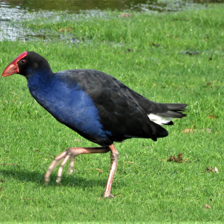

In [ ]:
# Image by: Wainuio, CC BY-SA 4.0, via Wikimedia Commons
image_url = "https://upload.wikimedia.org/wikipedia/commons/8/8b/Bird-8077%2C_Kapiti%2C_North_Island%2C_New_Zealand.jpg"
image = read_image(image_url)
image

In [ ]:
# Describing the image
prompt = "describe en\n"
output = paligemma.generate(
    inputs={
        "images": image,
        "prompts": prompt,
    }
)
print(output[len(prompt) :])

In this image we can see a bird on the ground. In the background there is water.


In [ ]:
# Answering questions about the image
prompt = "answer en is the bird flying?\n"
output = paligemma.generate(
    inputs={
        "images": image,
        "prompts": prompt,
    }
)
print(output[len(prompt) :])

no


In [ ]:
# Answering detailed questions about the image
prompt = "answer en What's the color of the beak?\n"
output = paligemma.generate(
    inputs={
        "images": image,
        "prompts": prompt,
    }
)
print(output[len(prompt) :])

red


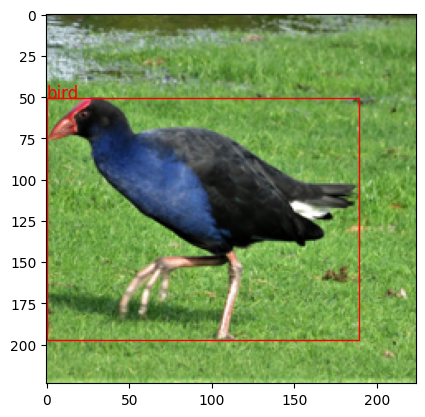

In [ ]:
# Object detection
prompt = "detect bird\n"
output = paligemma.generate(
    inputs={
        "images": image,
        "prompts": prompt,
    }
)
boxes, labels = parse_bbox_and_labels(output)
display_boxes(image, boxes, labels, (224, 224))

#### Prompting example: Optical Rharacter Recognition (OCR)

array([[[ 51,  80, 109],
        [ 44,  79, 110],
        [ 50,  83, 111],
        ...,
        [100,  85,  92],
        [ 99,  87,  96],
        [ 98,  88,  98]],

       [[112, 146, 163],
        [112, 147, 163],
        [116, 152, 165],
        ...,
        [111, 140, 157],
        [112, 142, 159],
        [111, 143, 161]],

       [[192, 200, 204],
        [191, 200, 204],
        [192, 201, 204],
        ...,
        [183, 194, 203],
        [183, 194, 202],
        [184, 195, 203]],

       ...,

       [[185, 186, 178],
        [185, 186, 177],
        [186, 187, 177],
        ...,
        [190, 185, 166],
        [189, 187, 168],
        [189, 187, 169]],

       [[161, 166, 139],
        [156, 162, 135],
        [155, 161, 133],
        ...,
        [125, 128,  91],
        [128, 129,  94],
        [131, 133,  96]],

       [[ 56,  54,  37],
        [ 55,  51,  35],
        [ 53,  48,  32],
        ...,
        [ 72,  50,  29],
        [ 72,  50,  29],
        [ 69,  50,  26]]], dtype=uint8)
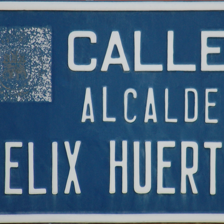

In [ ]:
# Image by: Raimundo Pastor, CC BY-SA 4.0, via Wikimedia Commons
image_url = "https://upload.wikimedia.org/wikipedia/commons/1/1b/Alcal%C3%A1_de_Henares_%28RPS_08-04-2017%29_Calle_Alcalde_F%C3%A9lix_Huerta%2C_placa_indicativa.png"
image = read_image(image_url)
image

In [ ]:
prompt = "ocr"
output = paligemma.generate(
    inputs={
        "images": image,
        "prompts": prompt,
    }
)
print(output[len(prompt) :])

 CALLE ALCALDE
ELIX HUERT
